In the first part we took a deep dive into the data and trends of shots based on three key variables. We developed an understanding of the distributions and probabilities associated with shots and goals, by representing, transforming and visualizing the data. A natural progression would now be to develop a model that takes in our three predictors (distance, angle and binary descriptor for a header) and returns a probability of a shot resulting in a goal. 


We are going to import our shot_matrix function from part 1 and use to recreate our data frame. 

In [264]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [265]:
#for extended notes and descriptions, visit part 1
#use nbimporter to extract our shot_matrix function from part 1
import nbimporter
from xG_model_part1 import shot_matrix
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from PlotPitch import draw_pitch
directory = '/Users/Ian/Desktop/IDanalytics/event_data'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))
all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df = pd.concat(all_leagues)

xG_model_part1.ipynb:49: RuntimeWarning: invalid value encountered in arccos
  "source": [


In [310]:
df = df.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])
df['header'] = pd.to_numeric(df['header'])
df['Goal'] = pd.to_numeric(df['Goal'])
df

,Goal,playerid,teamid,matchid,header,Y,X,Distance,Angle Radians,Angle Degrees
213,1,256992,3799,2500686,0,38.76,6.30,7.896050,0.755576,43.291300
302,0,334552,3772,2500686,1,28.56,17.85,18.660549,0.372069,21.317963
498,1,26389,3772,2500686,0,29.24,4.20,6.348039,0.851948,48.813019
577,0,276920,3772,2500686,0,14.28,16.80,25.905953,0.184838,10.590449
629,0,366760,3799,2500686,0,34.68,28.35,28.358154,0.256637,14.704224
...,...,...,...,...,...,...,...,...,...,...
642945,0,8561,1633,2500098,0,30.60,29.40,29.595946,0.244517,14.009788
643023,1,41174,1633,2500098,0,22.44,14.70,18.700898,0.309646,17.741433
643051,0,7879,1623,2500098,0,42.16,12.60,15.011516,0.410444,23.516712
643055,0,145692,1623,2500098,0,25.84,8.40,11.710918,0.461143,26.421528


Since our response variable (shot result) is categorical, we must apply appoaches that are know as classification. To introuce classification, let's look at an example. Assume we plot a random selection of shots from our data and classify them based on their result. For now we are going to focus on the distance predictor. 

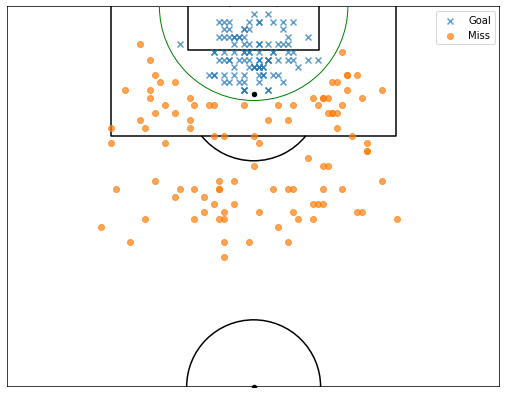

In [324]:
from PlotPitch import draw_pitch
idx_goal = np.where((df['Goal']==1) & (df['Distance'] < 12)) 
df_HS_goal = df.iloc[idx_goal]
idx_miss = np.where((df['Goal']==0) & (df['Distance']> 13)) 
df_HS_miss = df.iloc[idx_miss]


#probabilty of shot resulting in goals based on 
prob=np.array(df['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_HS_goal.head(100),x='Y', y='X',alpha=.7,marker='x')
misses = plt.scatter(data = df_HS_miss.head(100),x='Y', y='X',alpha=.7,marker='o')
ax.set_xlim(0,68)
plt.legend((goals,misses),('Goal','Miss'))
ax.set_ylim(52.5,0)
circle = plt.Circle((34,0),13,fill=False, color = 'Green')
ax.add_artist(circle)
plt.axis('off')

plt.show()


Now this is quite an assumption but let's stick with it for demonstration. Above we can see that there is a clear distinction between the two clusters, in blue and orange. The question is, if we want to predict future shots results based on the data above, how could we classify them. 

Since the data is easily seperable, we can create a boundary line, also know as a discriminant function, that will classify each response (0 or 1 for the result of a shot) based on the distance predictor variable. In the case above, this is a function that maps out a distance r from the center of the goal. The function, drawn in green, is defined by the equation $ y = \alpha x +\beta$, where x is the distance from goal and y in the binary response.  Specifically for the data above y = x -12. We can translate this into a classification model by applying the heaviside function to our discriminant, which returns a 0 or 1 response variable based on the value of y. 

$$
\begin{array}{rcl}
  H(y) & \equiv & \left\{\begin{array}{ll}
      0 & \mathrm{if}\ y > 0
      \\
      1 & \mathrm{if}\ y \leq 0
    \end{array}\right..
\end{array}
$$



The Heaviside function is a sharp boundary line, assigning hard 0 or 1s based on which side of the boundary the data point is on. This is the simpliest classification model but it requires the data to be cleanly seperable. 

Text(0.5, 1.0, 'Heaviside Function Classification for Shots')

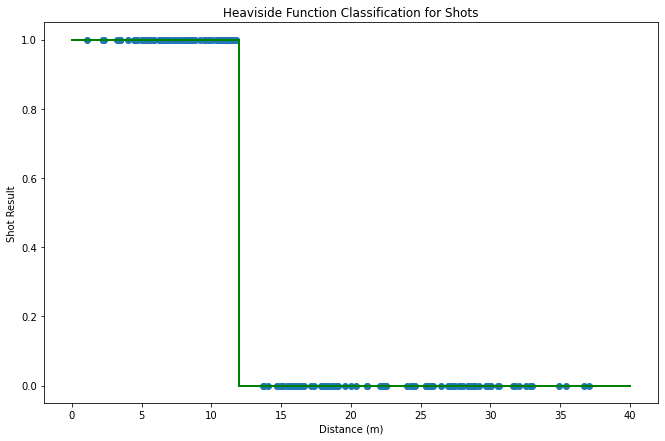

In [230]:
#plot the heaviside function on top of the responses for the seperable data above
df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))
plt.scatter(df_HS_predictor,df_HS_response)
plt.plot([0,12], [1, 1], 'k-', lw=2,c='green')
plt.plot([12,12], [0, 1], 'k-', lw=2,c='green')
plt.plot([12,40], [0, 0], 'k-', lw=2,c='green')
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.title('Heaviside Function Classification for Shots')


    

As we know, the data describing shots is not cleanly seperable, so the heaviside function is not useful when looking a more complex data. Alas, it serves as a natural progression into more advanced classification models. If we took a sample of our data, it might resemble the plot below. 

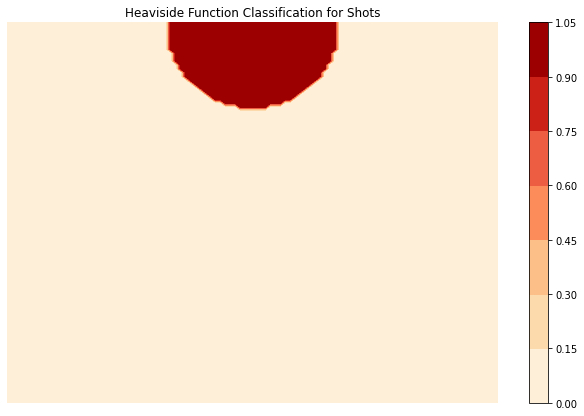

In [553]:
#we are going to create a contour plot to see how the heaviside function classifies
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from PlotPitch import draw_pitch 
def heaviside(Y):
    A = np.where(Y<=0, 0, 1)
    return A

def heaviside_int(x1):
    'computes heaviside step function'
    return heaviside(x1).astype(dtype = int)

fig, axes = plt.subplots(figsize=(11,7))

x0 = np.linspace(0., +68, 100)
x1 = np.linspace(0., +53, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
h_grid = heaviside_int(144-(x0_grid-34)**2-(x1_grid-53)**2)
plt.contourf(x0, x1, h_grid,cmap='OrRd')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Heaviside Function Classification for Shots')

plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()

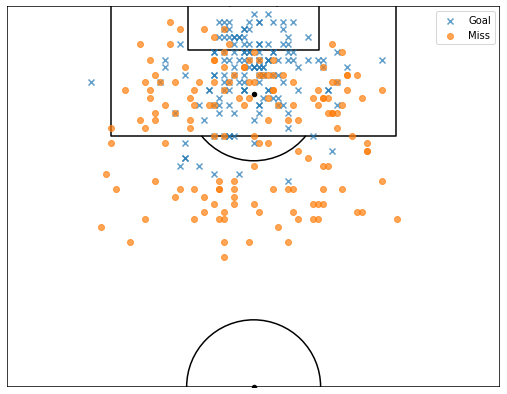

In [455]:
idx = np.where((df['Goal']==1) & (df['Distance'] < 25)) 
df_log_goal = df.iloc[idx]
idx = np.where((df['Goal']==0) & (df['Distance']> 5)) 
df_log_miss = df.iloc[idx]


#probabilty of shot resulting in goals based on 
prob=np.array(df['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_log_goal.head(150),x='Y', y='X',alpha=.7,marker='x')
misses = plt.scatter(data = df_log_miss.head(150),x='Y', y='X',alpha=.7,marker='o')
classifer = Arc(xy=(10,10),width=12,height=12)
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.legend((goals,misses),('Goal','Miss'))
plt.axis('off')


plt.show()

In the event where the data is not cleanly seperable we must adopt a different technique. 


$$
\begin{array}{rcl}
  G(y) & \equiv & \dfrac{1}{1 + e^{-y}} \equiv \dfrac{1}{1+e^{-(\alpha x_{1} +\beta x_{2}+\gamma x_{3} +\delta)}}
\end{array}
$$

The logistic function takes any value in the domain $(-\infty, +\infty)$ and produces a value in the range $(0, 1)$. Thus, given a value $y$, we can interpret $G(y)$ as a conditional probability that the shot results in a goal, $G(y) \equiv \mathrm{Pr}[\mbox{label is }1 \,|\, y]$.


Text(0.5, 1.0, 'Logistic Function')

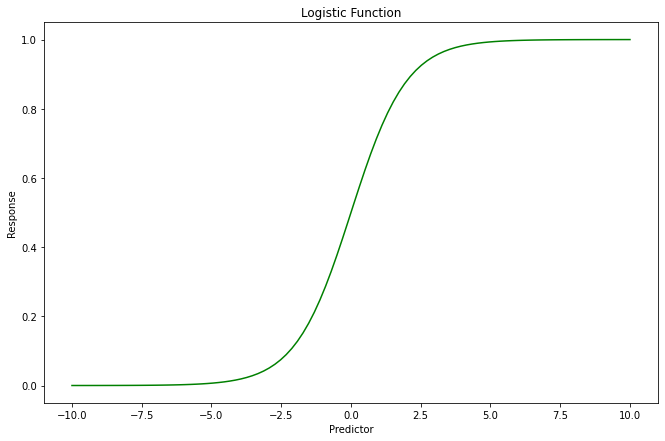

In [393]:
fig, ax = plt.subplots(figsize=(11, 7))

y = np.linspace(-10,10,100)
plt.plot(y,1/(1+np.exp(-(y))),c='Green')

plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Logistic Function')


In [774]:
#we are going to split the data into a test and train set(20% of it will go towards testing)
#for now we are going to model just the distance predictor
from sklearn import metrics 
from sklearn.model_selection import train_test_split
train_dis = df[['Goal','Distance']].copy()
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
                                                    train_dis['Goal'], test_size=0.20, 
                                                    random_state=10)
from sklearn.linear_model import LogisticRegression
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis,y_train_dis)
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)
pd.DataFrame(log_odds, 
             x_train_dis.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.14641592]] [0.09763449]


,coef
Distance,-0.146416


In [775]:
train_ang = df[['Goal','Angle Degrees']].copy()
x_train_ang, x_test_ang, y_train_ang, y_test_ang = train_test_split(train_ang.drop('Goal',axis=1), 
                                                    train_ang['Goal'], test_size=0.20, 
                                                    random_state=10)
lgm_ang = LogisticRegression()
lgm_ang.fit(x_train_ang,y_train_ang)
log_odds = lgm_ang.coef_[0]
print(lgm_ang.coef_, lgm_ang.intercept_)
pd.DataFrame(log_odds, 
             x_train_ang.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[0.05221106]] [-3.60645775]


,coef
Angle Degrees,0.052211


Text(0.5, 1.0, 'Heaviside Function Classification for Shots')

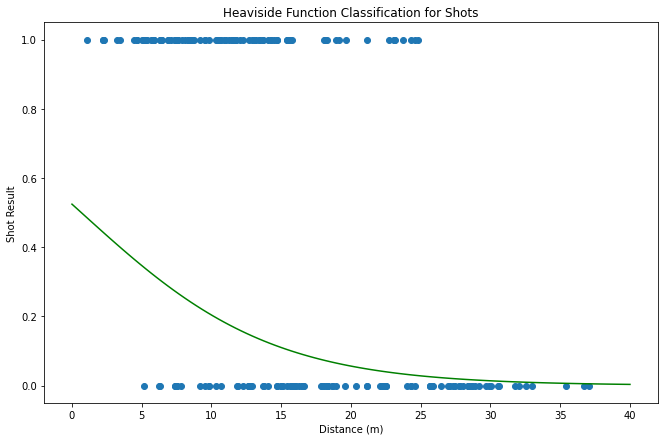

In [593]:
#plot the heaviside function on top of the responses for the seperable data above
df_HS_predictor = np.append(df_log_goal['Distance'].head(100), df_log_miss['Distance'].head(100))
df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))
plt.scatter(df_HS_predictor,df_HS_response)
y = np.linspace(0,40,100)
plt.plot(y,1/(1+np.exp((0.146*y-.097))),c='Green')
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.title('Heaviside Function Classification for Shots')


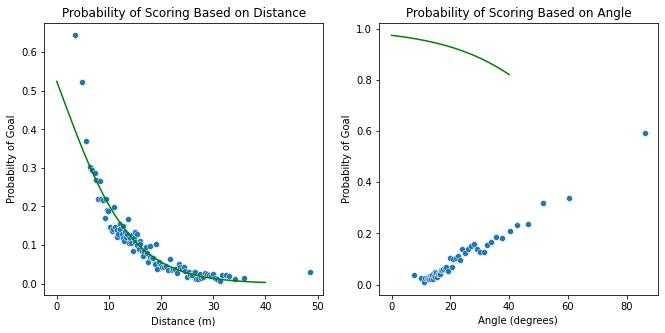

In [767]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(1, 2,figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob,ax=axes[0])
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,40,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.146*dis-.097))),ax= axes[0],color='green')


#same for the angle
df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=50)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob,ax=axes[1])
angle_trend.set(xlabel="Angle (degrees)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")

ang = np.linspace(0,40,100)
sns.lineplot(x = ang,y = 1/(1+np.exp((0.05221106*ang-3.60645775))),ax= axes[1],color='green')

plt.show()

In [725]:
df_shots =df[df['header']==0]
train = df_shots[['Goal','Distance','Angle Radians']].copy()
x_train, x_test, y_train, y_test = train_test_split(train.drop('Goal',axis=1), 
                                                    train['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm = LogisticRegression(random_state=0)
lgm.fit(x_train,y_train)
log_odds = lgm.coef_[0]
print(lgm.coef_, lgm.intercept_)
print(pd.DataFrame(log_odds, 
             x_train.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))

predictions = lgm.predict(x_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

[[-0.11023242  1.57148079]] [-1.02645936]
                   coef
Angle Radians  1.571481
Distance      -0.110232
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6068
           1       0.68      0.15      0.24       720

    accuracy                           0.90      6788
   macro avg       0.79      0.57      0.59      6788
weighted avg       0.88      0.90      0.87      6788



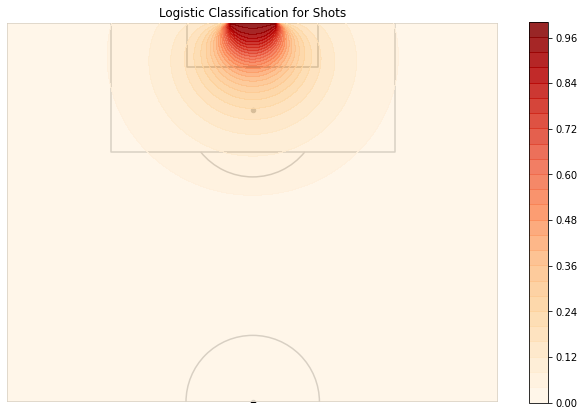

In [730]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(1.57148079*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  -0.11023242*np.sqrt((x1_grid)**2+(x0_grid)**2)-1.02645936)


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contourf(x_0,x1, h_grid,alpha=.85,cmap='OrRd',levels=25)


plt.title('Logistic Classification for Shots')

#plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()


(52.5, 0.0)

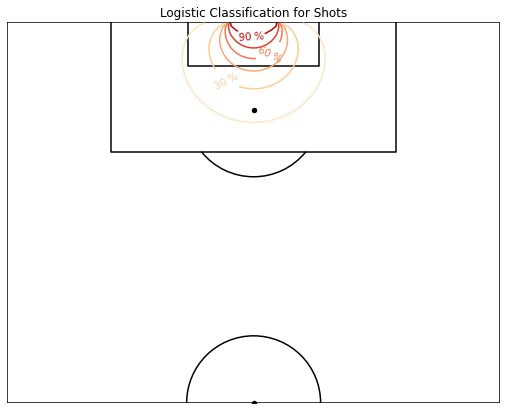

In [741]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(1.57148079*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  -0.11023242*np.sqrt((x1_grid)**2+(x0_grid)**2)-1.02645936)


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contour(x_0,x1, h_grid,alpha=1,cmap='OrRd',levels=6)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10)

plt.title('Logistic Classification for Shots')

#plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)

